In [1]:
#importing needed programs
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
%matplotlib inline

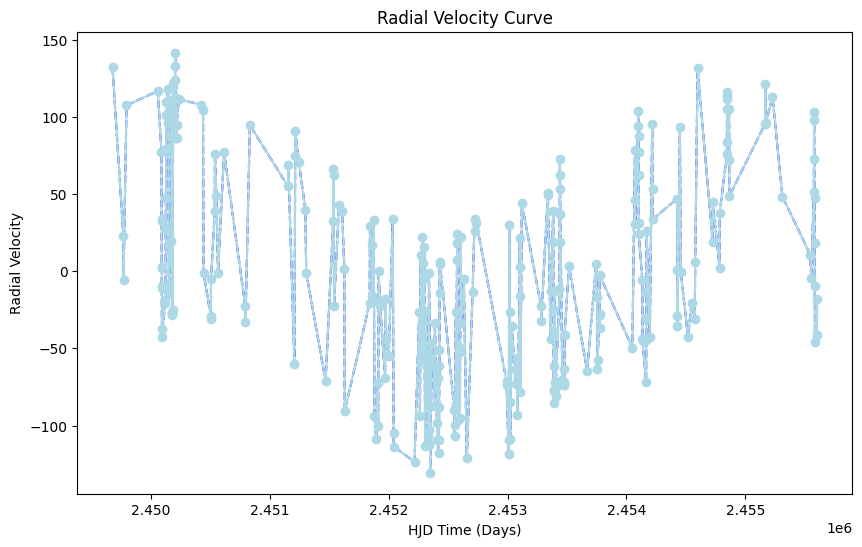

In [2]:
## Importing text file to be read as lines

tab = Table.read('55cnc.txt', format = 'ascii', names = ['HJD', 'RV', 'e_RV'])

#Arraying the data
data = np.array(tab)

x = tab['HJD']
y = tab['RV']
y_err = tab['e_RV']

#Plotting the figure
plt.figure(figsize=(10, 6))
plt.errorbar(x, y, fmt='o', linestyle='-', color='lightblue')
plt.plot(x, y, label='sin(x)', color='blue', linestyle='--')

# Labels and title
plt.xlabel('HJD Time (Days)')
plt.ylabel('Radial Velocity')
plt.title('Radial Velocity Curve')

#saving figure
plt.savefig('RadialVelocityCurve.pdf', bbox_inches='tight', facecolor='lightblue')
plt.show()

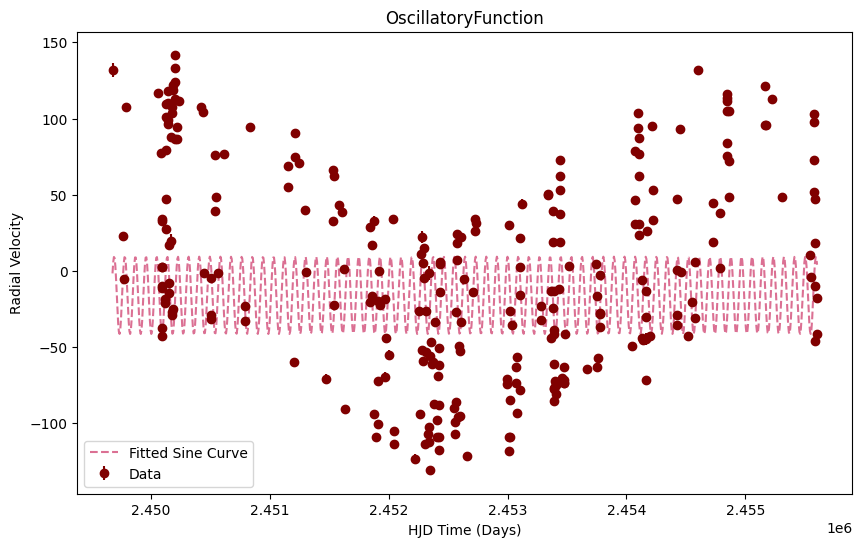

In [3]:
## Import needed programs
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

tab = Table.read('55cnc.txt', format = 'ascii', names = ['HJD', 'RV', 'e_RV'])

#Arraying the data
data = np.array(tab)

x = tab['HJD'] 
y = tab['RV']  
y_err = tab['e_RV']

#Load data
clean_lines = []
with open('55cnc.txt', 'r') as file:
    for line in file:
        parts = line.strip().split()
        if len(parts) == 3:
            try:
                # Try converting all 3 parts to float
                float_parts = [float(p) for p in parts]
                clean_lines.append(float_parts)
            except ValueError:
                continue  # Skip lines with non-numeric entries

#Define model
def model(t, K, P, phi, gamma):
    return K * np.sin(2 * np.pi * t / P + phi) + gamma

#Set parameters
params, _ = curve_fit(model, x, y, sigma=y_err, absolute_sigma=True)

#Make curve
x_fit = np.linspace(min(x), max(x), 1000)
y_fit = model(x_fit, *params)

#Plot and save
plt.figure(figsize=(10, 6))
plt.errorbar(x, y, y_err, fmt='o', color='maroon', label='Data')
plt.plot(x_fit, y_fit, linestyle='--', color='palevioletred', label='Fitted Sine Curve')
plt.xlabel('HJD Time (Days)')
plt.ylabel('Radial Velocity')
plt.title('OscillatoryFunction')
plt.legend()
plt.savefig('OscillatoryFunction.pdf',bbox_inches='tight',facecolor='lavenderblush')
plt.show()

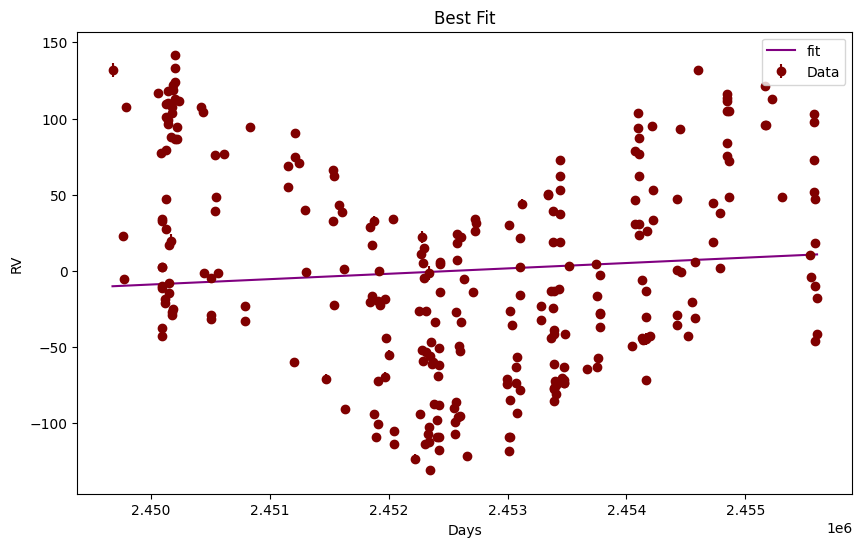

Slope (m_fit2): 0.00352548315435621
Intercept (b_fit2): -8646.392025297153


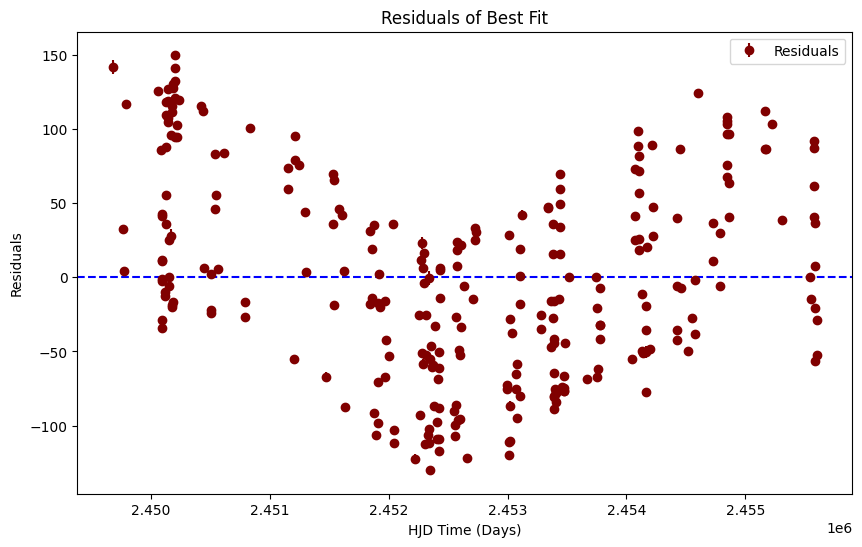

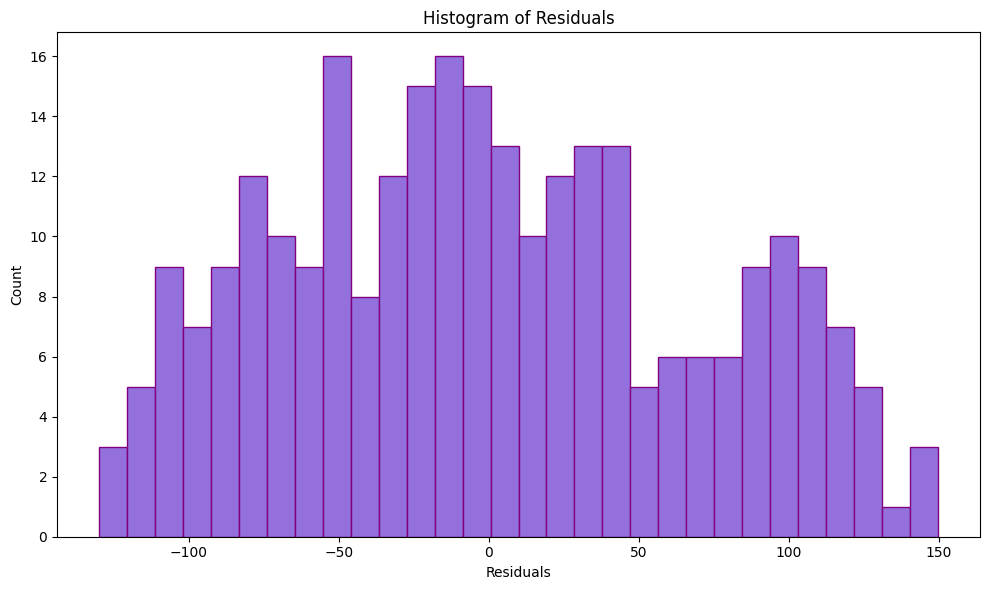

Standard deviation of residuals: 67.9915
Mean of RV measurement errors: 1.8061
Scatter in residuals is larger than the assumed experimental error.


In [4]:
## Import needed programs
from scipy import optimize

tab = Table.read('55cnc.txt', format = 'ascii', names = ['HJD', 'RV', 'e_RV'])

#Arraying the data
data = np.array(tab)

x = tab['HJD'] 
y = tab['RV']  
y_err = tab['e_RV']

#Load data
clean_lines = []
with open('55cnc.txt', 'r') as file:
    for line in file:
        parts = line.strip().split()
        if len(parts) == 3:
            try:
                # Try converting all 3 parts to float
                float_parts = [float(p) for p in parts]
                clean_lines.append(float_parts)
            except ValueError:
                continue  # Skip lines with non-numeric entries

#Get the best fit
def f_line(x, m, b):
    return m*x+b

params2, params_cov2 = optimize.curve_fit(f_line, x, y,sigma = y_err,absolute_sigma = True)

m_fit2 = params2[0]
b_fit2 = params2[1]

#Best fit model
plt.figure(figsize=(10, 6))
plt.errorbar(x, y, y_err, fmt='o', color='maroon', label='Data')
plt.plot(x, m_fit2 * x + b_fit2, '-', color='purple', label='fit')
plt.xlabel('Days')
plt.ylabel('RV')
plt.title('Best Fit')
plt.legend()
plt.show()

print(f"Slope (m_fit2): {m_fit2}")
print(f"Intercept (b_fit2): {b_fit2}")

#Obtain residuals
residuals = y - f_line(x, m_fit2, b_fit2)

#Plot residuals
plt.figure(figsize=(10, 6))
plt.errorbar(x, residuals, y_err, fmt='o', color='maroon', label='Residuals')
plt.axhline(0, color='blue', linestyle='--')
plt.xlabel('HJD Time (Days)')
plt.ylabel('Residuals')
plt.title('Residuals of Best Fit')
plt.legend()
plt.show()

#Plot histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins= 30, color='mediumpurple', edgecolor='purple')
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.title('Histogram of Residuals')
plt.tight_layout()
plt.savefig('residuals_histogram.png', bbox_inches = 'tight', facecolor = 'mistyrose')
plt.show()

#Calculate standard deviation of residuals
residual_std = np.std(residuals, ddof=1)  # ddof=1 for sample std
mean_yerr = np.mean(y_err)


#Measuring standard deviation
print(f"Standard deviation of residuals: {residual_std:.4f}")
print(f"Mean of RV measurement errors: {mean_yerr:.4f}")
if residual_std > mean_yerr:
    print("Scatter in residuals is larger than the assumed experimental error.")
else:
    print("Scatter in residuals is consistent with the assumed experimental error.")

In [6]:
from astropy.timeseries import LombScargle

x = np.array(tab['HJD'])
residuals = np.array(residuals)
y_err = np.array(y_err)

frequency, power = LombScargle(x, residuals, y_err).autopower()
best_frequency = frequency[np.argmax(power)]
best_period = 1/best_frequency

max_residual = np.max(np.abs(residuals))
print(f"Maximum absolute residual: {max_residual:.4f}")
min_residual = np.min(np.abs(residuals))
print(f"Minimum absolute residual: {min_residual:.4f}")

print(f"Best period: {best_period:.4f} days")

Maximum absolute residual: 149.7037
Minimum absolute residual: 0.0527
Best period: 14.6545 days


In [15]:
def sinusoid(x, A, omega, phi, offset):
    return A * np.sin(omega * x + phi) + offset

omega_guess = 2 * np.pi/best_period

params, cov = optimize.curve_fit(sinusoid, x, residuals, sigma = y_err, absolute_sigma = True, p0 = [5, omega_guess, 0, 0], maxfev = 10000)

A_fit, omega_fit, phi_fit, offset_fit = params

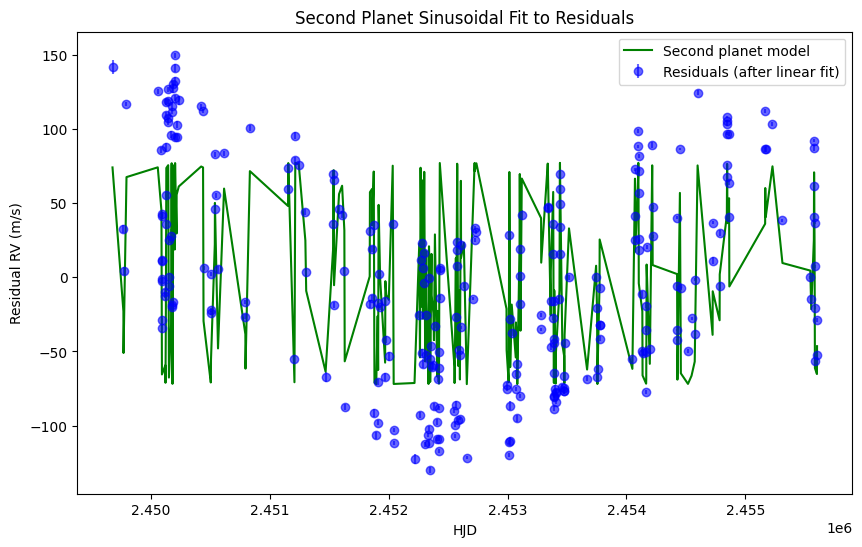

Maximum absolute residual: 149.7037
Minimum absolute residual: 0.0527


In [16]:
planet2_model = sinusoid(x, *params)

plt.figure(figsize=(10, 6))
plt.errorbar(x, residuals, y_err, fmt='o', color='blue', label='Residuals (after linear fit)', alpha = 0.6)
plt.plot(x, planet2_model, label = 'Second planet model', color='green')
plt.xlabel('HJD')
plt.ylabel('Residual RV (m/s)')
plt.title('Second Planet Sinusoidal Fit to Residuals')
plt.legend()
plt.savefig('sinusoidal.png', bbox_inches = 'tight', facecolor = 'white')
plt.show()

max_residual = np.max(np.abs(residuals))
print(f"Maximum absolute residual: {max_residual:.4f}")
min_residual = np.min(np.abs(residuals))
print(f"Minimum absolute residual: {min_residual:.4f}")

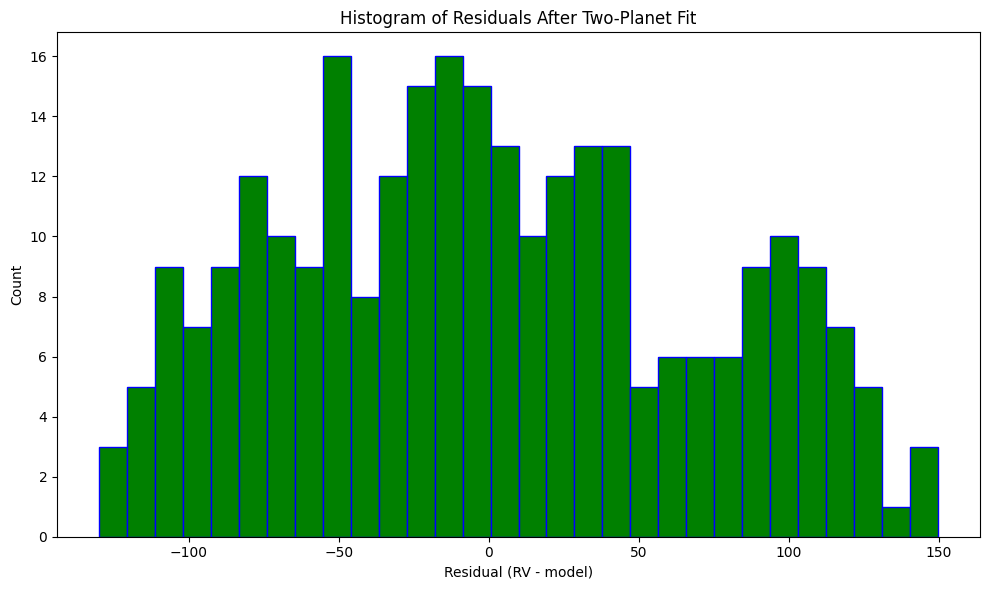

Standard deviation of residuals2: 67.9915


In [12]:
#Plot histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins= 30, color='green', edgecolor='blue')
plt.xlabel('Residual (RV - model)')
plt.ylabel('Count')
plt.title('Histogram of Residuals After Two-Planet Fit')
plt.tight_layout()
plt.savefig('residuals2_histogram.png', bbox_inches = 'tight', facecolor = 'white')
plt.show()

#Calculate standard deviation of residuals
residuals_std = np.std(residuals, ddof=1)

#Measuring standard deviation
print(f"Standard deviation of residuals2: {residuals_std:.4f}")

## For a planet on a circular orbit and zero inclination, the mass of the exoplanet is given by:  

𝑀exoplanet=(𝐾/28.4 m/s)(𝑃/365 days)⅓ (𝑀⋆)⅔

### where K is the amplitude of the RV signal (in m/s), P is the period of the planet (in days),  is the mass of the star in units of the mass of the Sun, and  is obtained in Jupiter masses. See example below. Use the amplitudes K and periods P obtained by your fit to calculate the mass of the exoplanets found in the RV data. Using information from the NASA Exoplanet Archive Links to an external site., determine which exoplanet(s) you discovered.

In [ ]:
#Calculating amplitude
149.7037-0.0527
149.651/2
# k = 74.8255

76.0164-0.3025
75.71390000000001/2
# k2 = 37.856950000000005

# best orbit period2 = 4559.8006 days
# best orbit period = 14.6545 days

# 𝑀exoplanet=(𝐾 / 28.4 m/s)(𝑃 / 365 days)⅓ (𝑀⋆)⅔

#(74.8255/28.4m/s)(14.6545/365days)^1/3 (0.905±0.015)⅔ = 0.8533932813(-) or 0.8347389375(+) or 0.8440918764
#simplify to 𝑀exo to ~ 0.844 for convenience.

#(37.856950000000005/28.4m/s)(4559.8006/365days)^1/3 (𝑀⋆)⅔ = 

#slope of best fit = 0.00352548315435621

#Closest alligned planet is 55 Cnc B. (for the first residual group).
#0.905±0.015

#There is no closest fit for the second residual group.